In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from transformers import DistilBertTokenizer, DistilBertModel

/Users/maxwellbederman/Desktop/School/EECS 448/box-officer/env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/maxwellbederman/Desktop/School/EECS 448/box-officer/env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
credits = pd.read_csv("tmdb_movie_metadata/tmdb_5000_credits.csv")
credits.rename(columns={'movie_id': 'id'}, inplace=True)
credits.drop("title", axis=1, inplace=True)
movies = pd.read_csv("tmdb_movie_metadata/tmdb_5000_movies.csv")
data = movies.merge(credits, on="id")
data = data[data["revenue"] != 0]
data = data[data["budget"] != 0]

print(data.head)

<bound method NDFrame.head of          budget                                             genres  \
0     237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1     300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2     245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3     250000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4     260000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
...         ...                                                ...   
4773      27000                     [{"id": 35, "name": "Comedy"}]   
4788      12000  [{"id": 27, "name": "Horror"}, {"id": 35, "nam...   
4792      20000  [{"id": 80, "name": "Crime"}, {"id": 27, "name...   
4796       7000  [{"id": 878, "name": "Science Fiction"}, {"id"...   
4798     220000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   

                                          homepage      id  \
0                      http://www.avatarmovie.com/   19995   
1    

In [113]:
print(data.columns)

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'cast', 'crew'],
      dtype='object')


In [114]:
print(data['cast'])

0       [{"cast_id": 242, "character": "Jake Sully", "...
1       [{"cast_id": 4, "character": "Captain Jack Spa...
2       [{"cast_id": 1, "character": "James Bond", "cr...
3       [{"cast_id": 2, "character": "Bruce Wayne / Ba...
4       [{"cast_id": 5, "character": "John Carter", "c...
                              ...                        
4798    [{"cast_id": 1, "character": "El Mariachi", "c...
4799    [{"cast_id": 1, "character": "Buzzy", "credit_...
4800    [{"cast_id": 8, "character": "Oliver O\u2019To...
4801    [{"cast_id": 3, "character": "Sam", "credit_id...
4802    [{"cast_id": 3, "character": "Herself", "credi...
Name: cast, Length: 4803, dtype: object


In [115]:
print(data.iloc[0]['genres'])

[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]


In [14]:
class cast_member:
    def __init__(self, name, character, gender):
        self.name = name
        self.character = character
        self.gender = gender
        
class crew_member:
    def __init__(self, name, job, department):
        self.name = name
        self.job = job
        self.department = department

In [15]:
def convert_dict_to_1d_list(json_str):
    json_dict = json.loads(json_str) 
    return_list = []
    for item in json_dict:
        return_list.append(item['name'])
    return return_list

def convert_dict_to_class_list(json_str, class_type, dimension1, dimension2, dimension3='none'):
    json_dict = json.loads(json_str) 
    return_list = []
    for item in json_dict:
        if class_type == 'cast_members':
            gender = item.get(dimension3, None)
            tmp_person = cast_member(item[dimension1], item[dimension2], gender)
            return_list.append(tmp_person)
        elif class_type == 'crew_members':
            department = item.get(dimension3, None)
            tmp_person = crew_member(item[dimension1], item[dimension2], department)
            return_list.append(tmp_person)
    return return_list

def get_director(crew_list):
    for item in crew_list:
        if item.job == 'Director':
            return item.name
    return 'none'  

def get_crew_member_count_by_job(crew_list, job_type):
    crew_member_count = 0
    for item in crew_list:
        if job_type in item.job:
            crew_member_count += 1
    return crew_member_count  

def get_department_size(crew_list, department):
    department_size = 0
    for item in crew_list:
        if department in item.department:
            department_size += 1
    return department_size

def get_cast_number(cast_list, gender):
    cast_count = 0
    for item in cast_list:
        if str(item.gender) == str(gender):
            cast_count += 1
    return cast_count  

In [16]:
x = data.copy()

x['genres']  =  x['genres'].apply(convert_dict_to_1d_list)
x['keywords'] = x['keywords'].apply(convert_dict_to_1d_list)  
x['production_companies'] = x['production_companies'].apply(convert_dict_to_1d_list)  
x['production_countries'] = x['production_countries'].apply(convert_dict_to_1d_list)

x['country'] = x['production_countries'].apply(lambda x:x[0] if len(x)>0 else None)

x['cast'] = x['cast'].apply(convert_dict_to_class_list, 
                                                              args=('cast_members', 'name', 'character', 'gender'))   
x['crew'] = x['crew'].apply(convert_dict_to_class_list, 
                                                              args=('crew_members', 'name', 'job', 'department'))  

x['director_name'] = x['crew'].apply(get_director)   

x['dominant_genre'] = x['genres'].apply(lambda x:x[0] if len(x)>0 else 'none')  

x['title_year'] = pd.to_datetime(x['release_date']).apply(lambda x:0 if pd.isnull(x.year) else int(x.year))

x['release_week'] = pd.to_datetime(x['release_date']).apply(lambda x:0 if pd.isnull(x.week) else int(x.week))

x['cast_size'] = x['cast'].apply(lambda x:len(x) if len(x)>0 else 0)
x['crew_size'] = x['crew'].apply(lambda x:len(x) if len(x)>0 else 0)
x['number_production_companies'] = x['production_companies'].apply(lambda x:len(x) if len(x)>0 else 0)

x['director_count'] = x['crew'].apply(get_crew_member_count_by_job, args=('Director',))   
x['writer_count'] = x['crew'].apply(get_crew_member_count_by_job, args=('Screenplay',))   
x['editor_count'] = x['crew'].apply(get_crew_member_count_by_job, args=('Editor',))  

x['sound_department_size'] = x['crew'].apply(get_department_size, args=('Sound',))   
x['costume_department_size'] = x['crew'].apply(get_department_size, args=('Costume & Make-Up',)) 
x['editing_department_size'] = x['crew'].apply(get_department_size, args=('Editing',)) 
x['production_department_size'] = x['crew'].apply(get_department_size, args=('Production',)) 
x['art_department_size'] = x['crew'].apply(get_department_size, args=('Art',)) 
x['camera_department_size'] = x['crew'].apply(get_department_size, args=('Camera',)) 
x['vx_department_size'] = x['crew'].apply(get_department_size, args=('Visual Effects',)) 

x['male_cast_count'] = x['cast'].apply(get_cast_number, args = ('2'))
x['female_cast_count'] = x['cast'].apply(get_cast_number, args = ('1'))
x['unstated_gender_cast_count'] = x['cast'].apply(get_cast_number, args = ('0'))

x['spoken_languages'] = x['spoken_languages'].apply(convert_dict_to_1d_list)

# x['genres'] = x['genres'].fillna(None)
# x['keywords'] = x['keywords'].fillna(None)
# x['overview'] = x['overview'].fillna(None)
# x['country'] = x['country'].fillna(None)
# x['director_name'] = x['director_name'].fillna(None)


In [17]:
def one_hot_encoder(df, column_to_encode, control_df, control_subset_size, control_column, output_prefix):
    control_list = set(control_df.nlargest(control_subset_size, control_column)[control_column])
    
    def encode_item(item):
        if isinstance(item, list):
            encoded = {output_prefix + elem.replace(" ", ""): 1 for elem in item if elem in control_list}
        else:
            encoded = {output_prefix + item.replace(" ", ""): 1 if item in control_list else 0}
        return encoded
    
    encoded_data = df[column_to_encode].apply(lambda x: encode_item(x) if pd.notna(x) else {})
    
    encoded_df = pd.DataFrame(list(encoded_data)).fillna(0).astype(int)
    
    df = df.drop(column_to_encode, axis=1).reset_index(drop=True)
    df = pd.concat([df, encoded_df], axis=1)
    
    return df


In [18]:
from collections import defaultdict
def calculate_average_revenue(df, column):
    revenue_sum = defaultdict(float)
    count = defaultdict(int)
    
    for index, row in df.iterrows():
        entities = [row[column]] if isinstance(row[column], str) else row[column]
        if entities is None:
            continue
        for entity in entities:
            revenue_sum[entity] += row['revenue']
            count[entity] += 1
    
    # Calculate average revenue
    average_revenue = {entity: revenue_sum[entity] / count[entity] for entity in revenue_sum}
    
    return average_revenue

def one_hot_encode_top_x_by_revenue(df, columns, top_x):
    one_hot_encoded_dfs = []  # To hold one-hot encoded DataFrames for each column before concatenating
    for column in columns:
        average_revenue = calculate_average_revenue(df, column)
        
        # Sort entities based on average revenue and select top X
        top_entities = sorted(average_revenue, key=average_revenue.get, reverse=True)[:top_x]
        
        # Prepare a dict to hold the encoded data
        encoded_data = {f'{column}_is_{entity}': [] for entity in top_entities}
        
        # Fill in the encoded data
        for index, row in df.iterrows():
            entities = [row[column]] if isinstance(row[column], str) else row[column]
            if entities is None:
                for entity in top_entities:
                    encoded_data[f'{column}_is_{entity}'].append(0)
                continue
            for entity in top_entities:
                encoded_data[f'{column}_is_{entity}'].append(1 if entity in entities else 0)
        
        # Convert the encoded data to a DataFrame
        encoded_df = pd.DataFrame(encoded_data, index=df.index)
        one_hot_encoded_dfs.append(encoded_df)
    
    # Concatenate all one-hot encoded DataFrames with the original DataFrame
    df = pd.concat([df] + one_hot_encoded_dfs, axis=1)
    
    return df

In [19]:
columns_to_encode = ['director_name', 'production_companies', 'genres', 'spoken_languages', 'country', ]
x_onehot = one_hot_encode_top_x_by_revenue(x, columns_to_encode, top_x=10000)

In [20]:
columns_to_drop = ['genres', 'homepage', 'id', 'keywords', 'original_language',
                   'original_title', 'production_companies',
                   'production_countries', 'release_date', 'spoken_languages', 
                   'status', 'title', 'director_name', 'country',
                   'cast', 'crew', 'id', 'dominant_genre', 'vote_count', 'popularity', 'vote_average']

x_cleaned = x_onehot.drop(columns=columns_to_drop)
x_cleaned = x_cleaned.fillna(0)

In [123]:
x_cleaned.columns[:25]

Index(['budget', 'overview', 'revenue', 'runtime', 'tagline', 'title_year',
       'release_week', 'cast_size', 'crew_size', 'number_production_companies',
       'director_count', 'writer_count', 'editor_count',
       'sound_department_size', 'costume_department_size',
       'editing_department_size', 'production_department_size',
       'art_department_size', 'camera_department_size', 'vx_department_size',
       'male_cast_count', 'female_cast_count', 'unstated_gender_cast_count',
       'director_name_is_Chris Buck', 'director_name_is_Kyle Balda'],
      dtype='object')

In [124]:
x_cleaned.columns[25:]

Index(['director_name_is_Lee Unkrich', 'director_name_is_Joss Whedon',
       'director_name_is_Chris Renaud', 'director_name_is_James Cameron',
       'director_name_is_Roger Allers', 'director_name_is_Tim Miller',
       'director_name_is_Colin Trevorrow', 'director_name_is_Robert Stromberg',
       'director_name_is_Pierre Coffin', 'director_name_is_Dan Scanlon',
       ...
       'country_is_Kyrgyz Republic', 'country_is_Algeria', 'country_is_Guyana',
       'country_is_Pakistan', 'country_is_Guadaloupe', 'country_is_Slovenia',
       'country_is_Afghanistan', 'country_is_Dominican Republic',
       'country_is_Cameroon', 'country_is_Kenya'],
      dtype='object', length=7517)

In [125]:
taglines = x_cleaned["tagline"].replace(0, "")
overview = x_cleaned["overview"].replace(0, "")

descriptions = taglines + " " + overview
descriptions = descriptions.map(lambda x: x.strip() if isinstance(x, str) else x)



In [126]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [127]:
input_ids = []
attention_mask = []
for description in descriptions:
    inputs = tokenizer(description, return_tensors='pt', max_length=500, truncation=True, padding='max_length')
    input_ids.append(inputs["input_ids"])
    attention_mask.append(inputs["attention_mask"])


In [21]:
x_cleaned = x_cleaned.drop(columns=["overview", "tagline"])

In [22]:
Y = x_cleaned['revenue']
X = x_cleaned.drop('revenue', axis=1)

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [23]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

gbr.fit(X_train, Y_train)

Y_train_pred = gbr.predict(X_train)
Y_test_pred = gbr.predict(X_test)

print("Training Set Performance:")
print("Mean Squared Error:", mean_squared_error(Y_train, Y_train_pred))
print("R^2 Score:", r2_score(Y_train, Y_train_pred))

print("\nTest Set Performance:")
print("Mean Squared Error:", mean_squared_error(Y_test, Y_test_pred))
print("R^2 Score:", r2_score(Y_test, Y_test_pred))

Training Set Performance:
Mean Squared Error: 6515983292470930.0
R^2 Score: 0.7876704203561268

Test Set Performance:
Mean Squared Error: 2.1902096074282304e+16
R^2 Score: 0.566683056970253


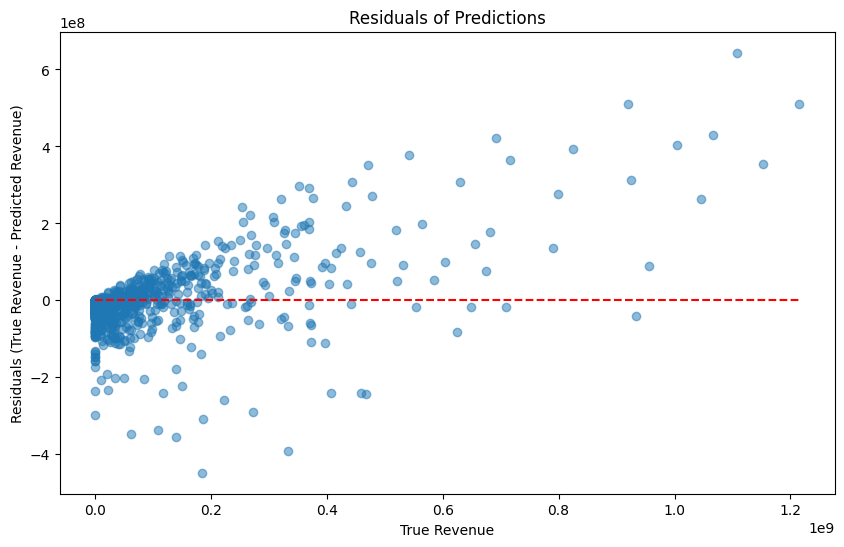

In [50]:
residuals = Y_test - Y_test_pred

plt.figure(figsize=(10, 6))
plt.scatter(Y_test, residuals, alpha=0.5)
plt.title('Residuals of Predictions')
plt.xlabel('True Revenue')
plt.ylabel('Residuals (True Revenue - Predicted Revenue)')
plt.hlines(y=0, xmin=Y_test.min(), xmax=Y_test.max(), colors='red', linestyles='--')
plt.show()


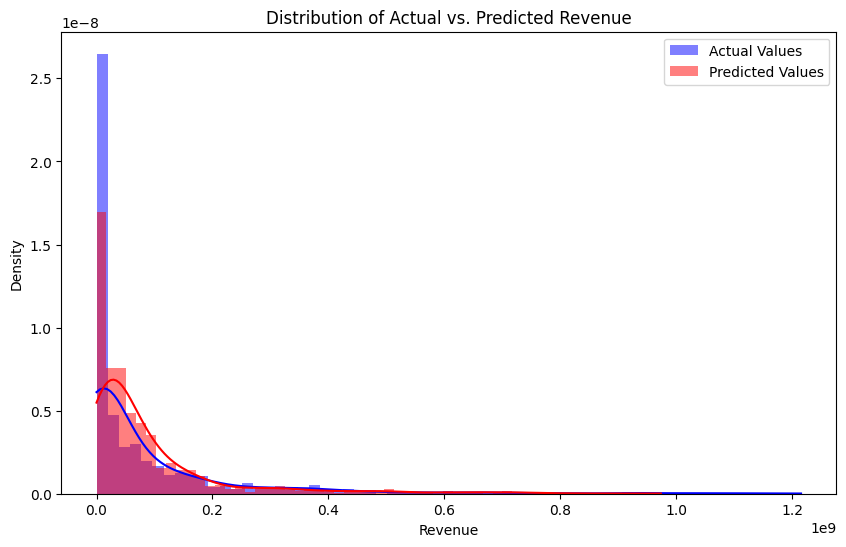

In [52]:
import seaborn as sns
plt.figure(figsize=(10, 6))

sns.histplot(Y_test, color="blue", label="Actual Values", kde=True, stat="density", linewidth=0)
sns.histplot(Y_test_pred, color="red", label="Predicted Values", kde=True, stat="density", linewidth=0)

plt.title('Distribution of Actual vs. Predicted Revenue')
plt.xlabel('Revenue')
plt.ylabel('Density')
plt.legend()
plt.show()


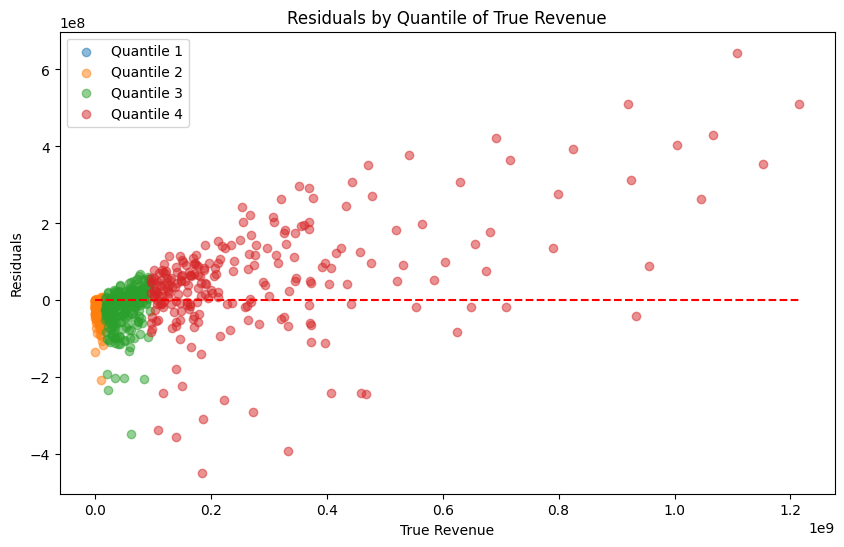

In [53]:
quantile_list = np.percentile(Y_test, [25, 50, 75, 100])

residuals = Y_test - Y_test_pred

plt.figure(figsize=(10, 6))
for i, quantile in enumerate(quantile_list):
    in_quantile = (Y_test <= quantile) & (Y_test > (quantile_list[i-1] if i > 0 else 0))
    plt.scatter(Y_test[in_quantile], residuals[in_quantile], alpha=0.5, label=f'Quantile {i+1}')

plt.title('Residuals by Quantile of True Revenue')
plt.xlabel('True Revenue')
plt.ylabel('Residuals')
plt.legend()
plt.hlines(y=0, xmin=Y_test.min(), xmax=Y_test.max(), colors='red', linestyles='--')
plt.show()

Index(['genres_is_Adventure', 'costume_department_size', 'crew_size',
       'genres_is_Drama', 'title_year',
       'production_companies_is_WingNut Films',
       'production_companies_is_Amblin Entertainment', 'release_week',
       'production_companies_is_Lucasfilm', 'runtime', 'genres_is_Animation',
       'production_companies_is_Fuji Television Network', 'male_cast_count',
       'director_name_is_James Cameron',
       'production_companies_is_Illumination Entertainment',
       'female_cast_count', 'vx_department_size',
       'production_companies_is_Lightstorm Entertainment', 'cast_size',
       'budget'],
      dtype='object')


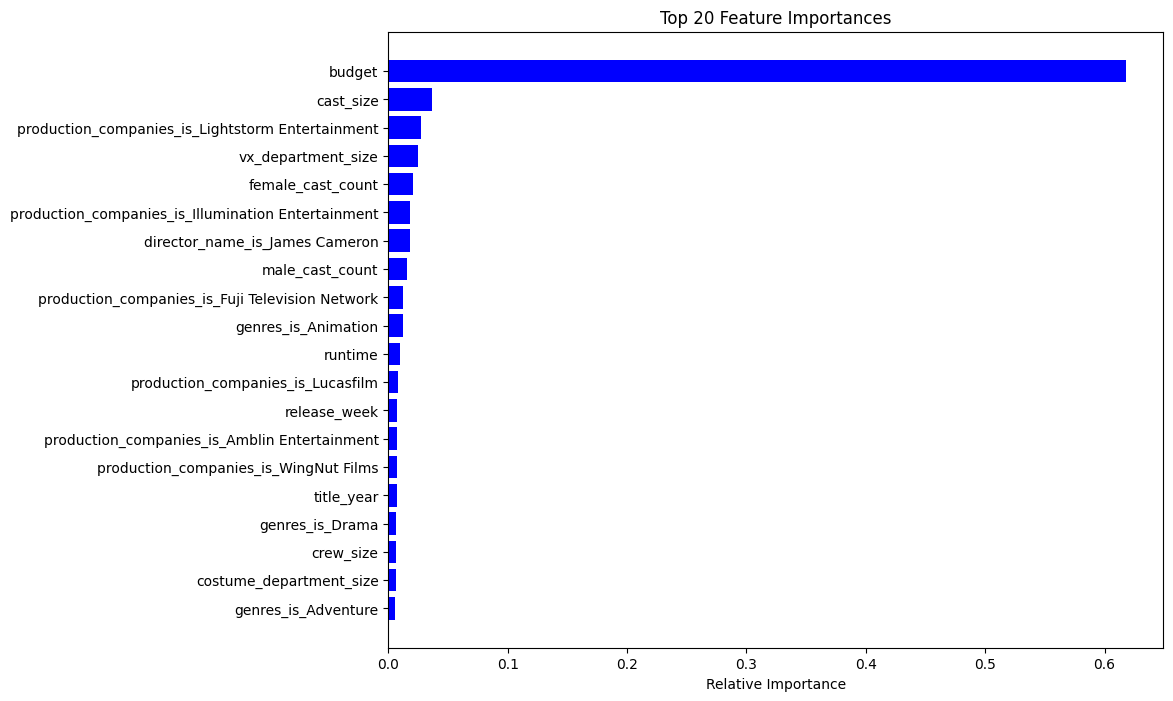

In [54]:
feature_importances = gbr.feature_importances_

indices = np.argsort(feature_importances)[-20:]

top_features = X_train.columns[indices]
print(top_features)
top_importances = feature_importances[indices]

# Plotting
plt.figure(figsize=(10, 8))
plt.title('Top 20 Feature Importances')
plt.barh(range(len(indices)), top_importances, color='b', align='center')
plt.yticks(range(len(indices)), [top_features[i] for i in range(len(indices))])
plt.xlabel('Relative Importance')
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(gbr, X, Y, cv=5, scoring='neg_mean_squared_error')
print("Cross-validated scores:", scores)


In [57]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score


base_estimator = DecisionTreeRegressor(max_depth=3)

ada_boost_reg = AdaBoostRegressor(estimator=base_estimator, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'loss': ['linear', 'square', 'exponential']
}

grid_search = GridSearchCV(ada_boost_reg, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X_train, Y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score (MSE):", -grid_search.best_score_)

best_reg = grid_search.best_estimator_
Y_test_pred = best_reg.predict(X_test)

mse = mean_squared_error(Y_test, Y_test_pred)
r2 = r2_score(Y_test, Y_test_pred)

print("Test Set Mean Squared Error:", mse)
print("Test Set R^2 Score:", r2)


/Users/noahmeislik/Desktop/Projects/box-officer/env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 500}
Best Score (MSE): 1.254738548028497e+16
Test Set Mean Squared Error: 8882784517663956.0
Test Set R^2 Score: 0.6589586548739099


In [130]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [131]:
class CustomDNN(nn.Module):
    def __init__(self, num_features, num_neurons=[128, 64, 32], dropout_rate=0.2):
        super(CustomDNN, self).__init__()
        self.nlp = DistilBertModel.from_pretrained('distilbert-base-uncased')
        
        # Adjusting the input shape for the first linear layer to include BERT's hidden state size (768) + num_features
        input_shape = 768 + num_features  # BERT hidden state size + number of numerical features
        self.layers = nn.ModuleList()
        for output_features in num_neurons:
            self.layers.append(nn.Linear(input_shape, output_features))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout_rate))
            input_shape = output_features

        self.layers.append(nn.Linear(num_neurons[-1], 1))

    def forward(self, input_ids, attention_mask, numerical_features):
        nlp_output = self.nlp(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = nlp_output[0][:, 0]  # Taking the CLS token's output
        
        # Concatenating BERT's CLS token output with numerical features
        combined_features = torch.cat([hidden_state, numerical_features], dim=1)
        
        for layer in self.layers:
            combined_features = layer(combined_features)
        return combined_features


In [132]:
from torch.utils.data import Dataset, DataLoader

class MovieDataset(Dataset):
    def __init__(self, input_ids, attention_mask, numerical_features, revenue):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.numerical_features = numerical_features
        self.revenue = revenue

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "numerical_features": self.numerical_features[idx],
            "revenue": self.revenue[idx],
        }

In [133]:
from sklearn.base import BaseEstimator, RegressorMixin
from torch.utils.data import DataLoader, TensorDataset

class PyTorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, model_class, num_features, num_neurons=[128, 64, 32], dropout_rate=0.2, learning_rate=0.001, epochs=100, batch_size=32):
        self.model_class = model_class
        self.num_features = num_features
        self.num_neurons = num_neurons
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = self.model_class(num_features, num_neurons, dropout_rate)

    def fit(self, X, y):
        # Convert numerical features and labels to tensors
        X_numerical, input_ids, attention_mask = X
        X_numerical = torch.tensor(X_numerical.astype(np.float32))
        y = torch.tensor(y.astype(np.float32)).view(-1, 1)

        # Create the dataset
        dataset = MovieDataset(input_ids, attention_mask, X_numerical, y)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        criterion = nn.MSELoss()

        self.model.train()
        for epoch in tqdm(range(self.epochs), desc="Epochs"):
            epoch_loss = 0.0
            for batch in dataloader:
                optimizer.zero_grad()
                
                # Unpack the batch
                batch_input_ids = batch["input_ids"]
                batch_attention_mask = batch["attention_mask"]
                batch_numerical_features = batch["numerical_features"]
                batch_labels = batch["labels"]

                # Forward pass
                outputs = self.model(batch_input_ids, batch_attention_mask, batch_numerical_features)
                loss = criterion(outputs, batch_labels)
                
                # Backward and optimize
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            
            # Optionally print the average loss per epoch
            print(f"Epoch {epoch+1}/{self.epochs}, Loss: {epoch_loss/len(dataloader)}")

        return self
    
    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X.astype(np.float32))
            predictions = self.model(X_tensor).squeeze()
        return predictions.numpy()
    
    def score(self, X, y):
        predictions = self.predict(X)
        return -mean_squared_error(y, predictions)


In [135]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


X_train_input_ids = X_train["input_ids"]
X_train_attention_mask = X_train["attention_mask"]
X_test_input_ids = X_test["input_ids"]
X_test_attention_mask = X_test["attention_mask"]

X_train = X_train.drop(columns=["input_ids", "attention_mask"])
X_test = X_test.drop(columns=["input_ids", "attention_mask"])

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train.to_numpy())
X_test_scaled = scaler_X.transform(X_test.to_numpy()) 
Y_train_scaled = scaler_y.fit_transform(Y_train.to_numpy().reshape(-1, 1)).flatten()

KeyError: 'input_ids'

In [137]:
X_combined = (X_train_scaled, X_train_input_ids, X_train_attention_mask)

model = PyTorchRegressor(CustomDNN, num_features=X_train_scaled.shape[1])

param_grid = {
    'num_neurons': [[128, 64, 32], [256, 128, 64]], # [72, 128, 256, 128, 72, 6, ]
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.01, 0.001, 0.0001],
    'epochs': [100],
    'batch_size': [32, 64]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_result = grid.fit(X_combined, Y_train_scaled)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


ValueError: Found input variables with inconsistent numbers of samples: [3, 3842]